In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from datetime import date
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option("display.max_rows", 100, "display.max_columns", 100)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def p(s):
    print(s)
    
pd.DataFrame.len = pd.Index.len = lambda x: print(len(x))

In [2]:
# Partition training, dev, and test data
seasonHist = pd.read_csv('seasonHist.csv')
X = seasonHist \
    .loc[:,seasonHist.columns.str.contains('-\d+') | seasonHist.columns.str.match('fanPts')] \
    .drop('fanPts',axis=1) \
    .fillna(0)
y = seasonHist.fanPts

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_dev_raw, X_test_raw, y_dev, y_test = train_test_split(X_test_raw, y_test, test_size=0.5, random_state=0)

# Scale and normalize data
mms = preprocessing.MinMaxScaler()
X_train_scaled = mms.fit_transform(X_train_raw)
X_dev_scaled, X_test_scaled = mms.transform(X_dev_raw), mms.transform(X_test_raw)

ss = preprocessing.StandardScaler()
X_train_std = ss.fit_transform(X_train_raw)
X_dev_std, X_test_std = ss.transform(X_dev_raw), ss.transform(X_test_raw)

# Manually downselect useful columns
keepCols = \
    X.columns.str.contains('fanPts') | \
    X.columns.str.contains('^complete_pass') | \
    X.columns.str.contains('rush_attempt') | \
    X.columns.str.contains('yards_gained') | \
    X.columns.str.contains('^touchdown')

X_train_select, X_dev_select, X_test_select = X_train_raw.loc[:,keepCols], X_dev_raw.loc[:,keepCols], X_test_raw.loc[:,keepCols]

### Linear Regression

#### Base model

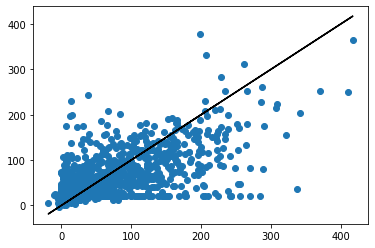

MAE: 31.7
RMSE: 47.4
R^2: 0.45


,touchdown-1,fumble-1,fanPts-1,yards_gained-1,rec_yards-1,rush_yards-1,rush_yards-3,rec_yards-3,yards_gained-3,pass_touchdown-3,yards_gained-2,rush_yards-2,rec_yards-2,rush_touchdown-3,rush_touchdown-2,pass_touchdown-2,interception-2,complete_pass-2,pass_attempt-2,incomplete_pass-2,incomplete_pass-1,fumble-2,complete_pass-1,complete_pass-3,pass_attempt-3,fumble-3,incomplete_pass-3,pass_attempt-1,interception-1,interception-3,rush_touchdown-1,fanPts-3,touchdown-2,pass_touchdown-1,touchdown-3,qb_hit-2,fanPts-2,qb_dropback-1,qb_hit-1,tackled_for_loss-1,rush_attempt-1,qb_hit-3,qb_dropback-3,tackled_for_loss-3,rush_attempt-3,no_huddle-1,qb_dropback-2,shotgun-1,no_huddle-3,shotgun-3,tackled_for_loss-2,no_huddle-2,yards_after_catch-1,rush_attempt-2,shotgun-2,yards_after_catch-2,air_yards-2,yards_after_catch-3,air_yards-3,air_yards-1
1,-67344989550.079,22448329848.953,11224164925.037,-1122416480.460,-11.962,-11.901,9.725,9.705,-9.575,7.765,6.991,-6.919,-6.892,6.532,5.209,4.729,4.477,3.764,-3.742,3.312,2.632,-2.427,2.301,-2.256,2.210,-1.972,-1.968,-1.963,1.783,-1.304,1.134,-1.073,-1.024,0.992,-0.677,-0.610,-0.593,-0.481,-0.474,0.469,-0.323,0.262,-0.256,0.184,-0.153,-0.106,-0.081,0.057,0.057,-0.052,-0.023,-0.018,-0.015,0.014,0.013,0.010,0.008,0.008,-0.007,0.003


In [3]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

m = linear_model.LinearRegression()
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

plt.scatter(y_dev, y_pred)
plt.plot(y_dev,y_dev,color='black')
plt.show()

mae = mean_absolute_error(y_dev, y_pred).round(1)
rmse = mean_squared_error(y_dev, y_pred, squared=False).round(1)
r2 = r2_score(y_dev, y_pred).round(2)
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()

### Ridge Regression

#### Base model

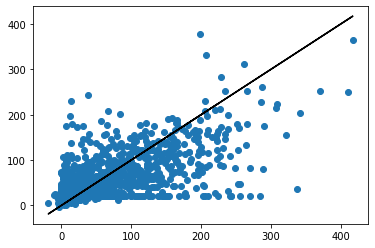

MAE: 31.7
RMSE: 47.4
R^2: 0.45


,rush_yards-3,rec_yards-3,yards_gained-3,pass_touchdown-3,yards_gained-1,rec_yards-1,rush_yards-1,rush_touchdown-3,yards_gained-2,rush_yards-2,rec_yards-2,rush_touchdown-2,pass_touchdown-2,interception-2,complete_pass-2,pass_attempt-2,incomplete_pass-2,incomplete_pass-1,fumble-2,complete_pass-1,complete_pass-3,pass_attempt-3,fumble-3,pass_attempt-1,incomplete_pass-3,interception-1,interception-3,rush_touchdown-1,fanPts-3,touchdown-2,pass_touchdown-1,fumble-1,touchdown-3,qb_hit-2,fanPts-2,qb_dropback-1,qb_hit-1,tackled_for_loss-1,touchdown-1,rush_attempt-1,qb_hit-3,qb_dropback-3,tackled_for_loss-3,rush_attempt-3,no_huddle-1,fanPts-1,qb_dropback-2,shotgun-1,no_huddle-3,shotgun-3,tackled_for_loss-2,no_huddle-2,yards_after_catch-1,rush_attempt-2,shotgun-2,yards_after_catch-2,yards_after_catch-3,air_yards-2,air_yards-3,air_yards-1
1,8.666,8.646,-8.517,7.738,6.903,-6.831,-6.770,6.506,6.330,-6.258,-6.231,5.192,4.712,4.443,3.733,-3.710,3.281,2.613,-2.426,2.282,-2.230,2.183,-1.958,-1.945,-1.941,1.762,-1.280,1.128,-1.067,-1.013,0.991,-0.938,-0.689,-0.611,-0.592,-0.480,-0.472,0.470,-0.412,-0.322,0.263,-0.255,0.184,-0.153,-0.106,0.093,-0.081,0.057,0.057,-0.052,-0.022,-0.018,-0.015,0.014,0.012,0.009,0.008,0.008,-0.007,0.003


In [4]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

m = linear_model.Ridge()
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

plt.scatter(y_dev, y_pred)
plt.plot(y_dev,y_dev,color='black')
plt.show()

mae = mean_absolute_error(y_dev, y_pred).round(1)
rmse = mean_squared_error(y_dev, y_pred, squared=False).round(1)
r2 = r2_score(y_dev, y_pred).round(2)
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV

Best parameters set found on development set:
{'alpha': 100000, 'normalize': False}


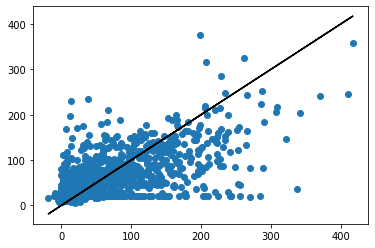

MAE: 31.6
RMSE: 47.3
R^2: 0.45


,qb_dropback-1,qb_dropback-2,rush_attempt-1,qb_dropback-3,fanPts-1,incomplete_pass-1,pass_attempt-1,tackled_for_loss-1,rush_attempt-3,fumble-1,fumble-2,incomplete_pass-2,qb_hit-2,incomplete_pass-3,complete_pass-2,qb_hit-1,no_huddle-1,tackled_for_loss-2,complete_pass-3,tackled_for_loss-3,yards_gained-1,shotgun-3,fanPts-2,rush_yards-1,fumble-3,pass_touchdown-3,pass_attempt-3,interception-1,no_huddle-3,rush_attempt-2,touchdown-2,shotgun-1,rush_touchdown-3,rec_yards-2,yards_gained-3,touchdown-3,yards_gained-2,interception-2,pass_attempt-2,rush_yards-3,yards_after_catch-1,fanPts-3,complete_pass-1,shotgun-2,rush_touchdown-2,yards_after_catch-2,yards_after_catch-3,no_huddle-2,touchdown-1,rec_yards-3,air_yards-3,rec_yards-1,rush_touchdown-1,pass_touchdown-2,rush_yards-2,air_yards-2,pass_touchdown-1,air_yards-1,interception-3,qb_hit-3
1,-0.288,-0.270,-0.233,-0.196,0.194,0.187,0.152,0.135,-0.130,-0.114,-0.109,-0.098,-0.092,0.085,0.081,-0.079,-0.068,0.063,-0.060,0.058,0.058,-0.057,0.056,0.052,-0.049,0.042,0.037,-0.032,0.030,-0.029,-0.027,0.026,-0.025,0.021,0.020,-0.019,0.019,0.018,-0.017,0.016,-0.015,-0.015,0.014,0.011,0.010,0.008,0.008,-0.007,-0.006,0.006,-0.006,0.005,0.005,-0.005,-0.005,0.004,0.004,0.003,0.003,0.002


In [5]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

grid = GridSearchCV(
    linear_model.Ridge(),
    {'alpha':[10**x for x in range(-4,6)],'normalize':[True,False]},
    n_jobs = -1,
    cv = 5
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# pd.DataFrame(grid.cv_results_)[['param_alpha','param_normalize','mean_test_score','std_test_score','rank_test_score']]

m = linear_model.Ridge(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

plt.scatter(y_dev, y_pred)
plt.plot(y_dev,y_dev,color='black')
plt.show()

mae = mean_absolute_error(y_dev, y_pred).round(1)
rmse = mean_squared_error(y_dev, y_pred, squared=False).round(1)
r2 = r2_score(y_dev, y_pred).round(2)
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

### Lasso Regression

#### Base model

In [6]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

m = linear_model.Lasso()
m.fit(X_train,y_train)
y_pred = regr.predict(X_dev)

plt.scatter(y_dev, y_pred)
plt.plot(y_dev,y_dev,color='black')
plt.show()

mae = mean_absolute_error(y_dev, y_pred).round(1)
rmse = mean_squared_error(y_dev, y_pred, squared=False).round(1)
r2 = r2_score(y_dev, y_pred).round(2)
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

coefs = pd.DataFrame([X_train.columns,regr.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

C:\Users\mrkawa\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11054.129647193477, tolerance: 3037.9150681688084
  positive)


NameError: name 'regr' is not defined

#### GridSearchCV

In [ ]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

grid = GridSearchCV(
    linear_model.Lasso(),
    {'alpha':[10**x for x in range(-4,6)],'normalize':[True,False]},
    n_jobs = -1,
    cv = 5
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# pd.DataFrame(grid.cv_results_)[['param_alpha','param_normalize','mean_test_score','std_test_score','rank_test_score']]

m = linear_model.Lasso(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

plt.scatter(y_dev, y_pred)
plt.plot(y_dev,y_dev,color='black')
plt.show()

mae = mean_absolute_error(y_dev, y_pred).round(1)
rmse = mean_squared_error(y_dev, y_pred, squared=False).round(1)
r2 = r2_score(y_dev, y_pred).round(2)
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV, hand-selected features

In [ ]:
X_train, X_dev, y_train, y_dev = X_train_select, X_dev_select, y_train, y_dev

grid = GridSearchCV(
    linear_model.Lasso(),
    {'alpha':[10**x for x in range(-4,6)],'normalize':[True,False]},
    n_jobs = -1,
    verbose=7,
    cv = 5
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# pd.DataFrame(grid.cv_results_)[['param_alpha','param_normalize','mean_test_score','std_test_score','rank_test_score']]

m = linear_model.Lasso(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

plt.scatter(y_dev, y_pred)
plt.plot(y_dev,y_dev,color='black')
plt.show()

mae = mean_absolute_error(y_dev, y_pred).round(1)
rmse = mean_squared_error(y_dev, y_pred, squared=False).round(1)
r2 = r2_score(y_dev, y_pred).round(2)
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV, hand-selected features

### Elastic Net Regression

#### Base model

In [ ]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

m = linear_model.ElasticNet()
m.fit(X_train,y_train)
y_pred = regr.predict(X_dev)

plt.scatter(y_dev, y_pred)
plt.plot(y_dev,y_dev,color='black')
plt.show()

mae = mean_absolute_error(y_dev, y_pred).round(1)
rmse = mean_squared_error(y_dev, y_pred, squared=False).round(1)
r2 = r2_score(y_dev, y_pred).round(2)
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

coefs = pd.DataFrame([X_train.columns,regr.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV

In [ ]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

grid = GridSearchCV(
    linear_model.ElasticNet(),
    {'alpha':[10**x for x in range(-4,6)],'normalize':[True,False]},
    n_jobs = -1,
    verbose=7,
    cv = 5
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# pd.DataFrame(grid.cv_results_)[['param_alpha','param_normalize','mean_test_score','std_test_score','rank_test_score']]

m = linear_model.ElasticNet(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

plt.scatter(y_dev, y_pred)
plt.plot(y_dev,y_dev,color='black')
plt.show()

mae = mean_absolute_error(y_dev, y_pred).round(1)
rmse = mean_squared_error(y_dev, y_pred, squared=False).round(1)
r2 = r2_score(y_dev, y_pred).round(2)
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### Automatic CV

In [ ]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

m = linear_model.ElasticNetCV(l1_ratio=[.25,.5,.75], random_state=0)
m.fit(X_train,y_train)
print(f'Alpha: {m.alpha_}')
print(f'l1 ratio: {m.l1_ratio_}')

y_pred = m.predict(X_dev)

plt.scatter(y_dev, y_pred)
plt.plot(y_dev,y_dev,color='black')
plt.show()

mae = mean_absolute_error(y_dev, y_pred).round(1)
rmse = mean_squared_error(y_dev, y_pred, squared=False).round(1)
r2 = r2_score(y_dev, y_pred).round(2)
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### Automatic CV, Scaled

In [ ]:
X_train, X_dev, y_train, y_dev = X_train_scaled, X_dev_scaled, y_train, y_dev

m = linear_model.ElasticNetCV(l1_ratio=[.25,.5,.75], random_state=0)
m.fit(X_train,y_train)
print(f'Alpha: {m.alpha_}')
print(f'l1 ratio: {m.l1_ratio_}')

y_pred = m.predict(X_dev)

plt.scatter(y_dev, y_pred)
plt.plot(y_dev,y_dev,color='black')
plt.show()

mae = mean_absolute_error(y_dev, y_pred).round(1)
rmse = mean_squared_error(y_dev, y_pred, squared=False).round(1)
r2 = r2_score(y_dev, y_pred).round(2)
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### Automatic CV, Standardized

In [ ]:
X_train, X_dev, y_train, y_dev = X_train_std, X_dev_std, y_train, y_dev

m = linear_model.ElasticNetCV(l1_ratio=[.25,.5,.75], random_state=0)
m.fit(X_train,y_train)
print(f'Alpha: {m.alpha_}')
print(f'l1 ratio: {m.l1_ratio_}')

y_pred = m.predict(X_dev)

plt.scatter(y_dev, y_pred)
plt.plot(y_dev,y_dev,color='black')
plt.show()

mae = mean_absolute_error(y_dev, y_pred).round(1)
rmse = mean_squared_error(y_dev, y_pred, squared=False).round(1)
r2 = r2_score(y_dev, y_pred).round(2)
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV, hand-selected features

In [ ]:
X_train, X_dev, y_train, y_dev = X_train_select, X_dev_select, y_train, y_dev

grid = GridSearchCV(
    linear_model.ElasticNet(),
    {
        'alpha':[10**x for x in range(-4,6)],
        'normalize':[True,False],
        'l1_ratio':[.25,.5,.75]
    },
    n_jobs = -1,
    verbose=7,
    cv = 5
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# pd.DataFrame(grid.cv_results_)[['param_alpha','param_normalize','mean_test_score','std_test_score','rank_test_score']]

m = linear_model.ElasticNet(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

plt.scatter(y_dev, y_pred)
plt.plot(y_dev,y_dev,color='black')
plt.show()

mae = mean_absolute_error(y_dev, y_pred).round(1)
rmse = mean_squared_error(y_dev, y_pred, squared=False).round(1)
r2 = r2_score(y_dev, y_pred).round(2)
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### Automatic CV, hand-selected features

In [ ]:
X_train, X_dev, y_train, y_dev = X_train_select, X_dev_select, y_train, y_dev

m = linear_model.ElasticNetCV(l1_ratio=[.25,.5,.75], random_state=0)
m.fit(X_train,y_train)
print(f'Alpha: {m.alpha_}')
print(f'l1 ratio: {m.l1_ratio_}')

y_pred = m.predict(X_dev)

plt.scatter(y_dev, y_pred)
plt.plot(y_dev,y_dev,color='black')
plt.show()

mae = mean_absolute_error(y_dev, y_pred).round(1)
rmse = mean_squared_error(y_dev, y_pred, squared=False).round(1)
r2 = r2_score(y_dev, y_pred).round(2)
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### Automatic CV, hand-selected features, scaled

In [ ]:
X_train, X_dev, y_train, y_dev = X_train_select, X_dev_select, y_train, y_dev ####

m = linear_model.ElasticNetCV(l1_ratio=[.25,.5,.75], random_state=0)
m.fit(X_train,y_train)
print(f'Alpha: {m.alpha_}')
print(f'l1 ratio: {m.l1_ratio_}')

y_pred = m.predict(X_dev)

plt.scatter(y_dev, y_pred)
plt.plot(y_dev,y_dev,color='black')
plt.show()

mae = mean_absolute_error(y_dev, y_pred).round(1)
rmse = mean_squared_error(y_dev, y_pred, squared=False).round(1)
r2 = r2_score(y_dev, y_pred).round(2)
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### Automatic CV, hand-selected features, standardized

In [ ]:
X_train, X_dev, y_train, y_dev = X_train_select, X_dev_select, y_train, y_dev ####

m = linear_model.ElasticNetCV(l1_ratio=[.25,.5,.75], random_state=0)
m.fit(X_train,y_train)
print(f'Alpha: {m.alpha_}')
print(f'l1 ratio: {m.l1_ratio_}')

y_pred = m.predict(X_dev)

plt.scatter(y_dev, y_pred)
plt.plot(y_dev,y_dev,color='black')
plt.show()

mae = mean_absolute_error(y_dev, y_pred).round(1)
rmse = mean_squared_error(y_dev, y_pred, squared=False).round(1)
r2 = r2_score(y_dev, y_pred).round(2)
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV, hand-selected features, force positive coefficients

In [ ]:
X_train, X_dev, y_train, y_dev = X_train_select, X_dev_select, y_train, y_dev

grid = GridSearchCV(
    linear_model.ElasticNet(),
    {
        'alpha':[10**x for x in range(-4,6)],
        'normalize':[True,False],
        'l1_ratio':[.25,.5,.75],
        'positive':[True]
    },
    n_jobs = -1,
    verbose=7,
    cv = 5
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# pd.DataFrame(grid.cv_results_)[['param_alpha','param_normalize','mean_test_score','std_test_score','rank_test_score']]

m = linear_model.ElasticNet(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

plt.scatter(y_dev, y_pred)
plt.plot(y_dev,y_dev,color='black')
plt.show()

mae = mean_absolute_error(y_dev, y_pred).round(1)
rmse = mean_squared_error(y_dev, y_pred, squared=False).round(1)
r2 = r2_score(y_dev, y_pred).round(2)
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### Automatic CV, hand-selected features, force positive coefficients

In [ ]:
X_train, X_dev, y_train, y_dev = X_train_select, X_dev_select, y_train, y_dev

m = linear_model.ElasticNetCV(l1_ratio=[.25,.5,.75], positive=[True], random_state=0)
m.fit(X_train,y_train)
print(f'Alpha: {m.alpha_}')
print(f'l1 ratio: {m.l1_ratio_}')

y_pred = m.predict(X_dev)

plt.scatter(y_dev, y_pred)
plt.plot(y_dev,y_dev,color='black')
plt.show()

mae = mean_absolute_error(y_dev, y_pred).round(1)
rmse = mean_squared_error(y_dev, y_pred, squared=False).round(1)
r2 = r2_score(y_dev, y_pred).round(2)
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

### Bayesian Ridge Regression

#### Base model

In [ ]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

m = linear_model.BayesianRidge()
m.fit(X_train,y_train)
y_pred = regr.predict(X_dev)

plt.scatter(y_dev, y_pred)
plt.plot(y_dev,y_dev,color='black')
plt.show()

mae = mean_absolute_error(y_dev, y_pred).round(1)
rmse = mean_squared_error(y_dev, y_pred, squared=False).round(1)
r2 = r2_score(y_dev, y_pred).round(2)
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

coefs = pd.DataFrame([X_train.columns,regr.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV

In [ ]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

grid = GridSearchCV(
    linear_model.BayesianRidge(),
    {
        'alpha_1':[10**x for x in range(-2,3)],
        'alpha_2':[10**x for x in range(-2,3)],
        'lambda_1':[10**x for x in range(-2,3)],
        'lambda_2':[10**x for x in range(-2,3)],
        'normalize':[True,False]
    },
    n_jobs = -1,
    verbose=7,
    cv = 3
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# pd.DataFrame(grid.cv_results_)[['param_alpha','param_normalize','mean_test_score','std_test_score','rank_test_score']]

m = linear_model.BayesianRidge(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

plt.scatter(y_dev, y_pred)
plt.plot(y_dev,y_dev,color='black')
plt.show()

mae = mean_absolute_error(y_dev, y_pred).round(1)
rmse = mean_squared_error(y_dev, y_pred, squared=False).round(1)
r2 = r2_score(y_dev, y_pred).round(2)
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV, hand-selected features

In [ ]:
X_train, X_dev, y_train, y_dev = X_train_select, X_dev_select, y_train, y_dev

grid = GridSearchCV(
    linear_model.BayesianRidge(),
    {
        'alpha_1':[10**x for x in range(-2,3)],
        'alpha_2':[10**x for x in range(-2,3)],
        'lambda_1':[10**x for x in range(-2,3)],
        'lambda_2':[10**x for x in range(-2,3)],
        'normalize':[True,False]
    },
    n_jobs = -1,
    verbose=7,
    cv = 3
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# pd.DataFrame(grid.cv_results_)[['param_alpha','param_normalize','mean_test_score','std_test_score','rank_test_score']]

m = linear_model.BayesianRidge(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

plt.scatter(y_dev, y_pred)
plt.plot(y_dev,y_dev,color='black')
plt.show()

mae = mean_absolute_error(y_dev, y_pred).round(1)
rmse = mean_squared_error(y_dev, y_pred, squared=False).round(1)
r2 = r2_score(y_dev, y_pred).round(2)
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

coefs = pd.DataFrame([X_train.columns,m.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs

#### GridSearchCV, hand-selected features, force positive coefficients

In [ ]:
X_train, X_dev, y_train, y_dev = X_train_select, X_dev_select, y_train, y_dev

grid = GridSearchCV(
    linear_model.BayesianRidge(),
    {
        'alpha_1':[10**x for x in range(-4,10)],
        'alpha_2':[10**x for x in range(-4,10)],
        'lambda_1':[10**x for x in range(-4,10)],
        'lambda_2':[10**x for x in range(-4,10)],
        'normalize':[True,False],
        'positive':[True]
    },
    n_jobs = -1,
    verbose=7,
    cv = 5
)

grid.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(grid.best_params_)
     
# pd.DataFrame(grid.cv_results_)[['param_alpha','param_normalize','mean_test_score','std_test_score','rank_test_score']]

clf = linear_model.BayesianRidge(**grid.best_params_)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_dev)

plt.scatter(y_dev, y_pred)
plt.plot(y_dev,y_dev,color='black')
plt.show()

mae = mean_absolute_error(y_dev, y_pred).round(1)
rmse = mean_squared_error(y_dev, y_pred, squared=False).round(1)
r2 = r2_score(y_dev, y_pred).round(2)
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

coefs = pd.DataFrame([X_train.columns,clf.coef_]).transpose()
coefs = coefs.reindex(coefs[1].abs().sort_values(ascending=False).index).set_index(0).transpose()
coefs